In [2]:
#%run -i '../../scripts/utility_readblt.py' 'mutau'
#%run -i '../../scripts/utility_readblt_inverseISO.py' 'mutau'
#%run -i '../../scripts/utility_readblt_ttTheoreticalUnc.py' 'mutau'

In [1]:
from utility_common import *
from utility_plotter import *
#import ROOT
from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline
#%qtconsole --style monokai
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

# 1. Read data and MC as dataframe

In [2]:
selection  = "mutau"
pickledir  = "/mnt/data/zchen/Analysis/pickle/{}/".format(selection)

In [3]:
def prepare_df_list(selection, nbjetcut):
    cuts = GetSelectionCut(selection, nbjetcut)

    Data = LoadDataframe(pickledir + "data2016").query(cuts)
    Fake = LoadDataframe(pickledir + "data2016_inverseISO").query("nBJets{}&(lepton1_pt > 30) & (triggerLepton>0)".format(nbjetcut))
    
    MCzz = LoadDataframe(pickledir + "mcdiboson").query(cuts)
    MCdy = LoadDataframe(pickledir + "mcdy").query(cuts)
    MCt  = LoadDataframe(pickledir + "mct").query(cuts)
    MCtt = LoadDataframe(pickledir + "mctt").query(cuts)
    # signal mc is tt+tW
    MCsg = pd.concat([MCt,MCtt],ignore_index=True)

    MCsgf = MCsg.query('genCategory in [16,21] ') # semilep and had
    MCsg0 = MCsg.query('genCategory in [1,2,3, 4,5,6,7,8,9, 10,11,12]') #other lep
    MCsg1 = MCsg.query('genCategory in [17]') #muh
    MCsg2 = MCsg.query('genCategory in [18,19,20]') #tauh
    MCsg3 = MCsg.query('genCategory in [13,14,15]') #mutau
    
    return [ Fake,MCzz,MCdy,MCsgf,MCsg0,MCsg1,MCsg2,MCsg3,Data],MCt,MCtt

# 2. Plot kinematics

In [4]:
pp = pd.read_csv("plotparameters.csv")
label_list = ["Fake","Diboson","V+Jets",r'$tt/tW \rightarrow l + h$ (other)',
              r'$tt/tW \rightarrow l + l$ (other) ',
              r'$tt/tW \rightarrow \mu + h$', 
              r'$tt/tW \rightarrow \tau + h$',
              r'$tt/tW \rightarrow \mu + \tau$',
              'data']
color_list = ["gray","#a32020","#e0301e","#eb8c00","gold","#49feec","deepskyblue","mediumpurple","k"]

In [6]:
for nbjetcut in ["==1",">1",">=1"]:
    ## 1. prepare df_list
    df_list,_,__ = prepare_df_list(selection, nbjetcut)
    ## 2. make plots
    plotoutdir = GetPlotDir(selection, nbjetcut)
    print(plotoutdir)
    for index, row in pp.iterrows():
        
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        if v == "triggerLepton" :
            continue
        plotter = SelectionPlotter(v,a,b,step,df_list,adjust=[0.01,1,1,1,1,1,1,1],hasFake=True)
        plotter.settingPlot(xl,label_list,color_list)
        plotter.makePlot(plotoutdir)
        # print out process
        print("making plots nbjet{0}: {1}/{2}".format(nbjetcut,index,len(pp)))
        clear_output(wait=True)
        plt.close()
        
print('finish all making plots')

finish all making plots


# 3. Counting

In [11]:
nbjetcut = ">1"
df_list,MCt,MCtt = prepare_df_list(selection,nbjetcut)
ctr = SelectionCounter()

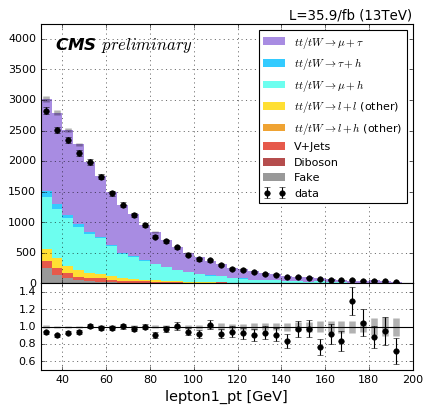

In [9]:
plt.rc("figure",facecolor="w",figsize=(6,4))

v,a,b,step,xl = "lepton1_pt",30,200,5,"lepton1_pt [GeV]"
plotter = SelectionPlotter(v,a,b,step,df_list,adjust=[0.05,1,1,1,1,1,1,1],hasFake=True)
plotter.settingPlot(xl,label_list,color_list)
plotter.makePlot()

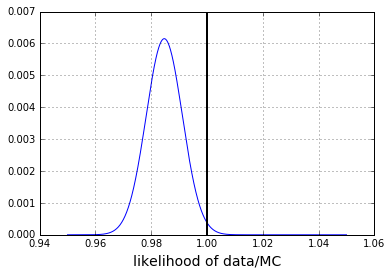

In [20]:
ratio = plotter.hdata/plotter.mctot
err   = sqrt((plotter.hdata**0.5/plotter.mctot)**2 + (plotter.mcerr/plotter.mctot)**2)


x = np.linspace(0.95,1.05,1000)
l = np.ones_like(x)
for i in range(len(ratio)):
    norm = (1/sqrt(2*np.pi*err[i]**2))
    l *= norm*np.exp(-(x-ratio[i])**2/(2*err[i]**2))
    #nll = nll+(x-ratio[i])**2/(2*err[i]**2)
l = l/np.sum(l)

plt.plot(x,l)
plt.xlabel("likelihood of data/MC",fontsize=14)
plt.axvline(1,c="k",lw=2)
plt.grid()

np.save("dataMCRatio/mutau_095to105", l)

In [12]:
print("(nBJets{})".format(nbjetcut))


print("MCtt: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=False)) )
print("MCtt width: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=True)) )

print("MCt : {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=False)) )
print("MCt width: {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=True)) )

(nBJets>1)
MCtt: [1, 86, 146, 0, 1, 1, 0, 1050, 1, 0, 8, 0, 34, 25, 18598, 0, 7986, 0, 429, 6, 3]
MCtt width: [0.9487230777740477, 78.89654438849539, 127.62205706723034, 0.0, 0.2642258405685425, 0.05976465716958046, 0.0, 952.1860645111883, 0.9972761869430542, 0.0, 6.823064841330051, 0.0, 29.491155522875488, 23.11021599173546, 17208.11951890186, 0.0, 7411.54836288275, 0.0, 392.41232019872405, 6.118517637252808, 3.0991350412368774]
MCt : [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 98, 0, 33, 0, 2, 0, 0]
MCt width: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.935192108154297, 0.0, 0.0, 0.0, 0.0, 1.013251781463623, 0.0, 94.5308758909814, 0.0, 31.270590856671333, 0.0, 2.1102006435394287, 0.0, 0.0]


In [9]:
ctr.countSlt_Scaled(df_list)

data:28078.0
TotalMC:46207.04222070937
------ MC break down ------
[1.88970000e+04 8.12623609e+01 1.11286138e+03 1.48570757e+01
 1.21786824e+03 1.04924413e+04 6.99597605e+02 1.36911543e+04]


In [11]:
for thisdf in [df_list[1],df_list[2], MCt, MCtt, df_list[-1]]:
    n = np.sum(thisdf.eventWeight)
    nerr = np.sum(thisdf.eventWeight**2)**0.5
    print('{:.2f},{:.2f}'.format(n,nerr))

81.26,7.71
1112.86,46.47
1426.55,42.72
24689.37,68.22
28078.00,167.56


In [12]:
# print Generator information
f = ROOT.TFile("../../data/root/2016MC.root")
print("MCtt : {}".format(ctr.countGen_ByTauDecay(f,'ttbar_inclusive')) )
temp = np.array(ctr.countGen_ByTauDecay(f,'t_tw'))
temp+= np.array(ctr.countGen_ByTauDecay(f,'tbar_tw'))
print("MCt  : {}".format(list(temp)) )

MCtt : [1811409.0, 1811532.0, 3620281.0, 57057.0, 54227.0, 111125.0, 418126.0, 407605.0, 763147.0, 642646.0, 626108.0, 2350887.0, 643368.0, 627277.0, 2353727.0, 22670017.0, 22653517.0, 4016590.0, 3923504.0, 14718933.0, 70930278.0]
MCt  : [23105.0, 23040.0, 46342.0, 694.0, 717.0, 1420.0, 5260.0, 5158.0, 9727.0, 8199.0, 8029.0, 30054.0, 8163.0, 8006.0, 29970.0, 290101.0, 289467.0, 50864.0, 50050.0, 187515.0, 904067.0]


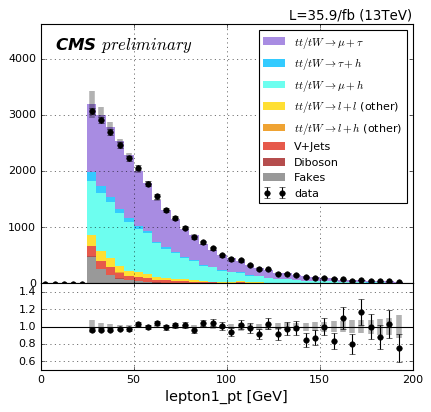